# Linear elasticity

Whenever a force or a load is applied to a solid, the body deforms. Stress analysis relate loads and deformations. Elasticity theory deals with small (reversible) deformations, i.e., the body returns to its original size and shape when the load is removed. Within this range, the distances between atoms in the solid, or, alternatively, the atom–atom bonds, are stretched or compressed, but not broken. In order to remain in the elastic range, the fractional changes in interatomic distances (on a microscopic scale) or in the body’s gross dimensions (on a macroscopic scale) must be less than 0.2%. When loads or deformations exceed the elastic range, the changes in the shape of the body are not recovered when the load is removed. This type of irreversible deformation is defined plastic deformation. On a microscopic level, atomic bonds are broken and new bonds are formed. The maximum extent of plastic deformation is breakage or fracture of the material. Instead of load (or force) and deformation, elasticity theory utilizes the related quantities stress and strain. 

## Problem equations
The equations governing the linear elastic problem for an isotropic body $\Omega$ can be written as:

$$
\begin{align}
    &\nabla \cdot \sigma + f = 0, && \quad \text{equilibrium condition} \\
    &\sigma= \lambda \mathrm{tr}(\epsilon)I + 2 \mu \epsilon, &&\quad \text{constitutive equation} \\
    &\epsilon= \frac{1}{2}\left(\nabla u + (\nabla u )^T\right), && \quad \text{strain compatibility equation}
\end{align}
$$

where $\sigma$ is the stress tensor, $f$ is the body force per unit volume, $\lambda$ and $\mu$ are Lamé parameters for the material in $\Omega$, $I$ is the identity tensor, $\mathrm{tr}$ is the trace operator on a tensor, $\epsilon$ is the symmetric strain tensor, and $u$ is the displacement vector field.

### Material properties
Since we are assuming a material macroscopically homogeneous (same physical properties at every point) and isotropic (same physical properties in any direction): the physical relationship can be expressed by only 2 (independent) elastic constants, the Lamé parameters. The Lamé parameters and conventional elastic moduli ($E$, $\nu$, $G$) are linked by the following relation:

$$
\begin{align}
    &E = \frac{\mu(\lambda + 2\mu)}{\lambda + \mu} \\
    &\nu = \frac{\lambda}{2(\lambda + \mu)} \\
    &G = \frac{E}{2(1 + \nu)} = \mu 
\end{align}
$$
In addition, we recall that the Lamé first parameter can be calculated as $\lambda = \frac{\nu E}{(1+\nu)(1-2\nu)}$.

By using the strain compatibility equation in the constitutive equation, we get:
$$
\begin{align}
    \sigma &= \lambda(\nabla \cdot u)I + \mu(\nabla u + (\nabla u)^T)
\end{align}
$$

Note that we could have written the PDE above as a single vector PDE for $u$, which is the governing PDE for the unknown $u$ (Navier's) equation. However, it is convenient to keep the current representation of the PDE for the derivation of the variational formulation.

## The variational formulation
The variational formulation of the PDE consists of forming the inner product of the PDE with a *vector* test function $v\in\hat{V}$, where $\hat{V}$ is a vector-valued test function space, and integrating over the domain $\Omega$:
$$
\begin{align}
    -\int_{\Omega}(\nabla \cdot \sigma)\cdot v ~\mathrm{d} x = \int_{\Omega} f\cdot v ~\mathrm{d} x.
\end{align}
$$ù

Since $\nabla \cdot \sigma$ contains second-order derivatives of our unknown $u$, we integrate this term by parts
$$
    -\int_{\Omega}(\nabla \cdot \sigma)\cdot v ~\mathrm{d} x =\int_{\Omega}\sigma : \nabla v ~\mathrm{d}x - \int_{\partial\Omega} (\sigma \cdot n)\cdot v~\mathrm{d}x,
$$

where the colon operator is the inner product between tensors (summed pairwise product of all elements), and $n$ is the outward unit normal at the boundary. The quantity $\sigma \cdot n$ is known as the *traction* or stress vector at the boundary, and often prescribed as a boundary condition. We here assume that it is prescribed on a part $\partial \Omega_T$ of the boundary as $\sigma \cdot n=T$. On the remaining part of the boundary, we assume that the value of the displacement is given as Dirichlet condition (and hence the boundary integral on those boundaries are $0$). We thus obtain:
$$
    \int_{\Omega} \sigma : \nabla v ~\mathrm{d} x = \int_{\Omega} f\cdot v ~\mathrm{d} x + \int_{\partial\Omega_T}T \cdot v~\mathrm{d} s.
$$

If we now insert for $\sigma$ its representation with the unknown $u$, we can obtain our variational formulation: Find $u\in V$ such that 
$$
    a(u,v) = L(v)\qquad  \forall v \in \hat{V},
$$

where
$$
\begin{align}
    a(u,v)&=\int_{\Omega}\sigma(u):\nabla v ~\mathrm{d}x\\
    \sigma(u)&=\lambda(\nabla \cdot u)I+\mu (\nabla u + (\nabla u)^T)\\
    L(v)&=\int_{\Omega}f\cdot v~\mathrm{d} x + \int_{\partial\Omega_T}T\cdot v~\mathrm{d}s
\end{align}
$$

One can show that the inner product of a symmetric tensor $A$ and an anti-symmetric tensor $B$ vanishes. If we express $\nabla v$ as a sum of its symmetric and anti-symmetric parts, only the symmetric part will survive in the product $\sigma : \nabla v$ since $\sigma$ is a symmetric tensor. Thus replacing $\nabla v$ by the symmetric gradient $\epsilon(v)$ gives rise to a slightly different variational form
$$

    a(u,v)= \int_{\Omega}\sigma(u):\epsilon(v)~\mathrm{d} x,
$$
where $\epsilon(v)$ is the symmetric part of $\nabla v$:
$$
    \epsilon(v)=\frac{1}{2}\left(\nabla v + (\nabla v)^T\right)
$$
The formulation is what naturally arises from minimization of elastic potential energy and is a more popular formulation than the original formulation.

## Implementation
The modules that will be used are imported:

In [40]:
import numpy as np

import ufl
from ufl import ds, dx, grad, inner

from dolfinx import fem, io, mesh, plot
from dolfinx.io import gmshio # to import gmsh functions
from dolfinx import geometry # to define the line plot
from dolfinx import default_scalar_type
import dolfinx.fem.petsc

from mpi4py import MPI

from petsc4py.PETSc import ScalarType

import matplotlib.pyplot as plt

### Class definition

In [41]:
class linear_elasticty():
    def __init__(self):
        # Domain
        # self.domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([1, 0.2, 0.2])], [20, 6, 6], cell_type=mesh.CellType.hexahedron)
        self.domain, self.tags, self.ft = gmshio.read_from_msh("pipe.msh", MPI.COMM_WORLD, gdim = 3)
        self.tdim = self.domain.topology.dim
        self.fdim = self.tdim - 1
        self.domain.topology.create_connectivity(self.fdim, self.tdim)

        # Functional spaces
        self.V = fem.functionspace(self.domain, ("Lagrange", 1, (self.domain.geometry.dim,)))

        # Test and trial functions
        self.ds = ufl.Measure("ds", domain=self.domain)
        self.u = ufl.TrialFunction(self.V)
        self.v = ufl.TestFunction(self.V)

    def parameters(self, rho, g, lambda_, mu):
        self.rho = rho
        self.g = g
        self.lambda_ = lambda_
        self.mu = mu

    def boundaryConditions(self, bc):

        def innerRadius(x):
            return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

        def outerRadius(x):
            return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1.2, rtol=1e-2)

        # Dirichlet boundary conditions
        inner_facets = mesh.locate_entities_boundary(self.domain, self.fdim, innerRadius)
        outer_facets = mesh.locate_entities_boundary(self.domain, self.fdim, outerRadius)

        # Markers
        marked_facets = np.hstack([inner_facets, outer_facets])
        marked_values = np.hstack([np.full_like(inner_facets, 1), np.full_like(outer_facets, 2)])
        sorted_facets = np.argsort(marked_facets)
        facet_tag = mesh.meshtags(self.domain, self.fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

        inner_dofs = fem.locate_dofs_topological(self.V, facet_tag.dim, facet_tag.find(1))
        outer_dofs = fem.locate_dofs_topological(self.V, facet_tag.dim, facet_tag.find(2))
        
        bc = np.array((0,) * self.domain.geometry.dim, dtype=default_scalar_type)

        self.bc = [fem.dirichletbc(bc, inner_dofs, self.V)]
        
        # Neumann boundary conditions
        n = ufl.FacetNormal(self.domain)
        P_intr = fem.Constant(self.domain, default_scalar_type(-100000.0))  # Internal pressure value, adjust as needed
        self.traction = P_intr * n

    def assemble(self):
        def sigma(u, lambda_, mu):
            return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*mu*epsilon(u)

        def epsilon(u):
            return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

        self.f = fem.Constant(self.domain, default_scalar_type((0.0, 0.0, - self.rho * self.g)))
        self.a = ufl.inner(sigma(self.u, self.lambda_, self.mu), epsilon(self.v)) * ufl.dx
        self.L = ufl.dot(self.f, self.v) * ufl.dx + ufl.dot(self.traction, self.v) * self.ds

    def solve(self):
        self.problem = fem.petsc.LinearProblem(self.a, self.L, bcs=self.bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        self.solution = self.problem.solve()

        def sigma(u, lambda_, mu):
            return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*mu*epsilon(u)

        def epsilon(u):
            return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
        
        self.stressField = sigma(self.solution, self.lambda_, self.mu)
        self.strainField = epsilon(self.solution)                

        return self.solution

Problem solution

In [42]:
# Scaled variable
E = 1e6 # Pa
nu = 0.33

G = E / (2*(1+nu))

lame1 = nu * E /((1+nu)*(1-2*nu))
lame2 = G

print(f"Young's modulus = {E*1e-9:.2f} GPa")
print(f"Poisson's ratio = ", nu)
print(f"Shear modulus = {G*1e-9:.2f} GPa")
print(f"Lamé first parameter = {lame1*1e-9:.2f} GPa")
print(f"Lamé second parameter = {lame2*1e-9:.2f} GPa")

u_D = np.array([0, 0, 0], dtype=default_scalar_type)

rho = 6560 # kg/m3
g = 9.81

problem = linear_elasticty()

# Volume of the mesh = volume integral
dx_subdomain = ufl.Measure("dx", domain=problem.domain)
volume = fem.assemble_scalar(fem.form(1 * dx_subdomain))
print("---------")
print(f"Volume = ", volume)

problem.parameters(rho, g / volume, lame1, lame2)
problem.boundaryConditions(u_D)
problem.assemble()

uh = problem.solve()

Young's modulus = 0.00 GPa
Poisson's ratio =  0.33
Shear modulus = 0.00 GPa
Lamé first parameter = 0.00 GPa
Lamé second parameter = 0.00 GPa
Info    : Reading 'pipe.msh'...
Info    : 15 entities
Info    : 26964 nodes
Info    : 153496 elements
Info    : Done reading 'pipe.msh'                                                                                
---------
Volume =  4.806641479701841


## Visualization
displayed using [pyvista](https://docs.pyvista.org/).


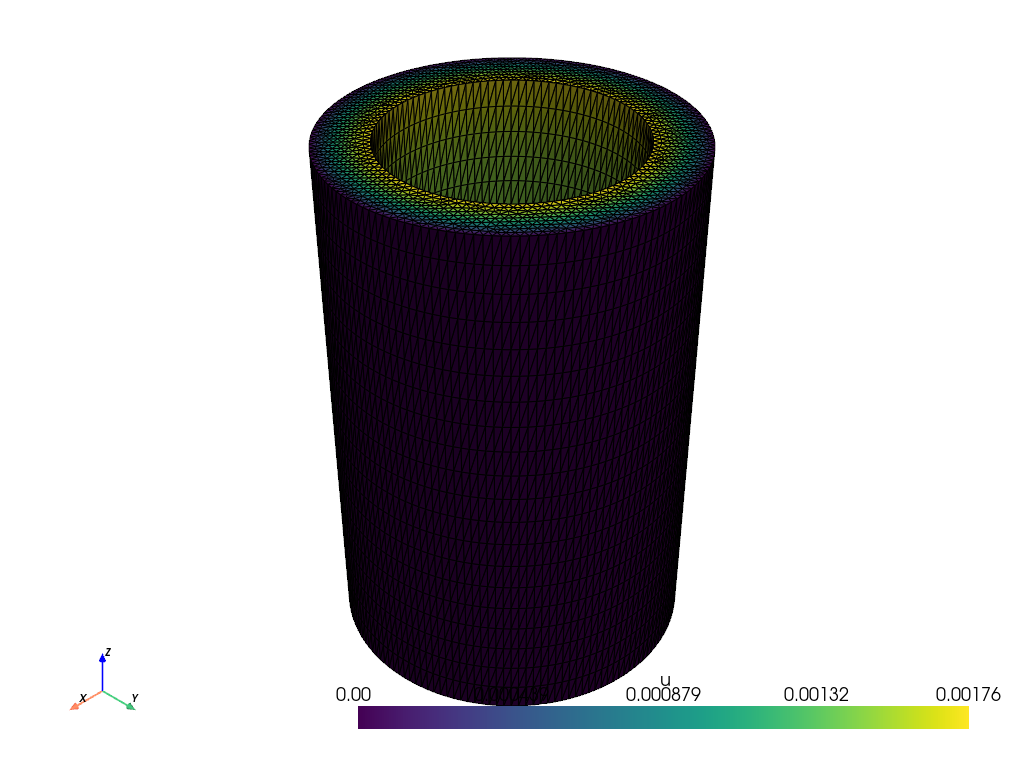

In [43]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(problem.V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   figure_as_array = p.screenshot("deflection.png")

# We could also use Paraview for visualizing this. We save the solution with XDMFFile.
# After opening the file deformation.xdmf in Paraview and pressing Apply, one can press the Warp by vector button Warp
# by vector or go through the top menu (Filters->Alphabetical->Warp by Vector) and press Apply.
# We can also change the color of the deformed beam by changing the value in the color menu color from Solid Color to Deformation.
with io.XDMFFile(problem.domain.comm, "deformation.xdmf", "w") as xdmf:
    xdmf.write_mesh(problem.domain)
    uh.name = "Deformation"
    xdmf.write_function(uh)

## Stress computation
As soon as the displacement is computed, we can compute various stress measures. We will compute the von Mises stress defined as $\sigma_m=\sqrt{\frac{3}{2}s:s}$ where $s$ is the deviatoric stress tensor $s(u)=\sigma(u)-\frac{1}{3}\mathrm{tr}(\sigma(u))I$.

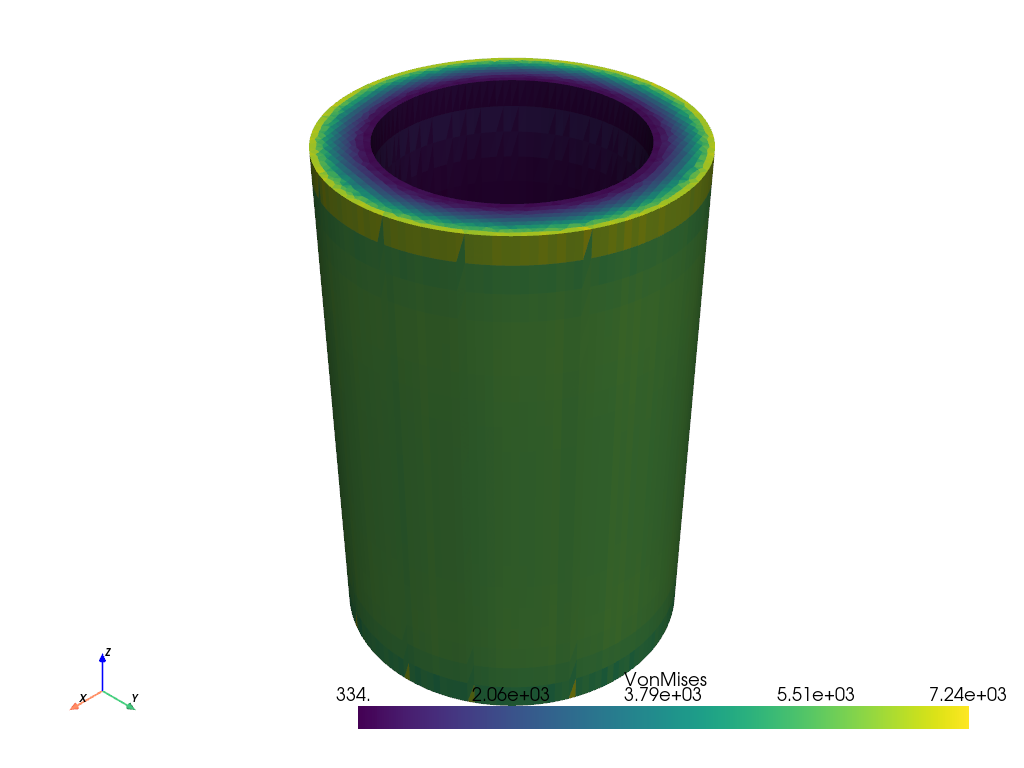

In [44]:
deviatoric_stress = problem.stressField -1./3*ufl.tr(problem.stressField)*ufl.Identity(len(problem.solution))
von_Mises = ufl.sqrt(3./2*ufl.inner(deviatoric_stress, deviatoric_stress))

V_von_mises = fem.functionspace(problem.domain, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
stresses = fem.Function(V_von_mises)
stresses.interpolate(stress_expr)

warped.cell_data["VonMises"] = stresses.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   stress_figure = p.screenshot(f"stresses.png")

   